# Test des Transformers - Augmentation & Features

Ce notebook teste :
- **ImageAugmenter** : flip, rotation, brightness, noise, zoom
- **ImageRandomCropper** : random/center/corners avec padding
- **ImageHistogram** : extraction de features histogramme
- **ImagePCA** : réduction dimensionnalité
- **ImageStandardScaler** : standardisation

## 1. Configuration et Imports

In [23]:
import sys
import logging
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Configuration paths
project_root = Path.cwd().parent.parent
# sys.path.insert(0, str(project_root))

from src.features.Pipelines.Transformateurs.image_loaders import ImageLoader
from src.features.Pipelines.Transformateurs.image_preprocessing import (
    ImageResizer, ImageNormalizer
)
from src.features.Pipelines.Transformateurs.image_augmentation import (
    ImageAugmenter, ImageRandomCropper
)
from src.features.Pipelines.Transformateurs.image_features import (
    ImageHistogram, ImagePCA, ImageStandardScaler
)

# Configuration logging et matplotlib
logging.basicConfig(
    level=logging.INFO,
    format='%(levelname)s - %(message)s'
)
plt.rcParams['figure.figsize'] = (15, 10)

print(f"Project root: {project_root}")
print("✅ Setup complet")

Project root: /home/cepa/DST/projet_DS/Data_Pipeline/Data_Pipeline
✅ Setup complet


## 2. Chargement des Données

In [24]:
# Chemins vers les données
data_dir = project_root / 'data' / 'raw' / 'COVID-19_Radiography_Dataset' / 'COVID-19_Radiography_Dataset'
categories = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

# Collecter chemins d'images
image_paths = []
labels = []

for cat in categories:
    cat_path = data_dir / cat / 'images'
    if cat_path.exists():
        imgs = sorted(list(cat_path.glob('*.png')))[:10]
        image_paths.extend(imgs)
        labels.extend([cat] * len(imgs))
        print(f"{cat}: {len(imgs)} images")

print(f"\nTotal: {len(image_paths)} images")

COVID: 10 images
Normal: 10 images
Lung_Opacity: 10 images
Viral Pneumonia: 10 images

Total: 40 images
Normal: 10 images
Lung_Opacity: 10 images
Viral Pneumonia: 10 images

Total: 40 images


In [25]:
# Préparation de base (load + resize + normalize)
prep_pipeline = Pipeline([
    ('load', ImageLoader(color_mode='L', verbose=False)),
    ('resize', ImageResizer(img_size=(128, 128), verbose=False)),
    ('norm', ImageNormalizer(method='minmax', verbose=False))
])

images = prep_pipeline.fit_transform(image_paths)

print(f"\n📊 Images préparées:")
print(f"  Shape: {images.shape}")
print(f"  Range: [{images.min():.2f}, {images.max():.2f}]")
print(f"  Mean: {images.mean():.3f}")
print(f"  Std: {images.std():.3f}")


📊 Images préparées:
  Shape: (40, 128, 128)
  Range: [0.00, 1.00]
  Mean: 0.515
  Std: 0.243


## 3. TEST 1: ImageAugmenter - Augmentations Multiples

In [26]:
print("\n" + "="*70)
print("TEST 1: ImageAugmenter - Toutes les augmentations")
print("="*70)

augmenter = ImageAugmenter(
    flip_horizontal=True,
    flip_vertical=False,
    rotation_range=15,
    brightness_range=(0.8, 1.2),
    noise_std=0.02,
    zoom_range=(0.9, 1.1),
    probability=1.0,  # Appliquer à toutes les images
    seed=42,
    verbose=True
)

images_augmented = augmenter.fit_transform(images[:8])

print(f"\nImages augmentées: {augmenter.n_images_augmented_}/8")

INFO - Augmenting 8 images (p=1.0)...



TEST 1: ImageAugmenter - Toutes les augmentations


Augmentation: 100%|██████████| 8/8 [00:00<00:00, 36.26it/s]
INFO - Augmentation completed: 8/8 images augmented (100.0%)
Augmentation: 100%|██████████| 8/8 [00:00<00:00, 36.26it/s]
INFO - Augmentation completed: 8/8 images augmented (100.0%)



Images augmentées: 8/8


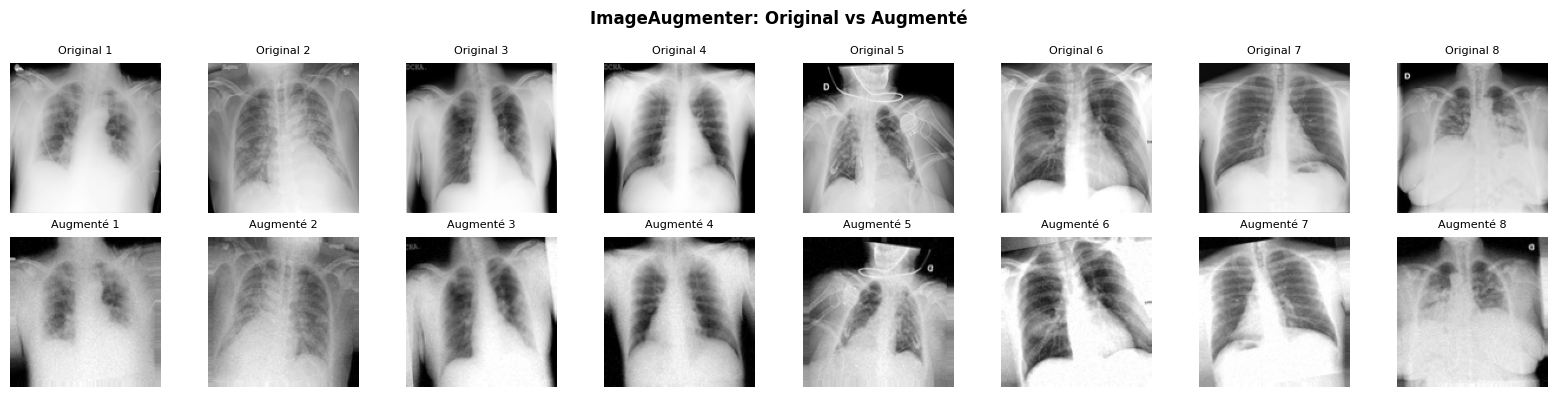

In [27]:
# Visualisation
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    # Original
    axes[0, i].imshow(images[i], cmap='gray')
    axes[0, i].set_title(f'Original {i+1}', size=8)
    axes[0, i].axis('off')
    
    # Augmenté
    axes[1, i].imshow(images_augmented[i], cmap='gray')
    axes[1, i].set_title(f'Augmenté {i+1}', size=8)
    axes[1, i].axis('off')

plt.suptitle('ImageAugmenter: Original vs Augmenté', size=12, weight='bold')
plt.tight_layout()
plt.show()

## 4. TEST 2: Reproductibilité avec Seed

In [29]:
print("\n" + "="*70)
print("TEST 2: Reproductibilité avec seed")
print("="*70)

# Avec seed fixe
aug1 = ImageAugmenter(rotation_range=30, seed=42, verbose=False)
aug2 = ImageAugmenter(rotation_range=30, seed=42, verbose=False)

result1 = aug1.fit_transform(images[:1])
result2 = aug2.fit_transform(images[:1])

# Sans seed
aug3 = ImageAugmenter(rotation_range=30, seed=None, verbose=False)
aug4 = ImageAugmenter(rotation_range=30, seed=None, verbose=False)

result3 = aug3.fit_transform(images[:1])
result4 = aug4.fit_transform(images[:1])

print(f"\nAvec seed=42:")
print(f"  Résultat 1 == Résultat 2: {np.allclose(result1, result2)} ✅")
print(f"\nSans seed (random):")
print(f"  Résultat 3 == Résultat 4: {np.allclose(result3, result4)} (attendu: False)")


TEST 2: Reproductibilité avec seed

Avec seed=42:
  Résultat 1 == Résultat 2: True ✅

Sans seed (random):
  Résultat 3 == Résultat 4: True (attendu: False)


/tmp/ipykernel_7438/159430244.py:14: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7438/159430244.py:14: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/cepa/DST/projet_DS/Data_Pipeline/Data_Pipeline/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cepa/DST/projet_DS/Data_Pipeline/Data_Pipeline/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cepa/DST/projet_DS/Data_Pipeline/Data_Pipeline/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(b

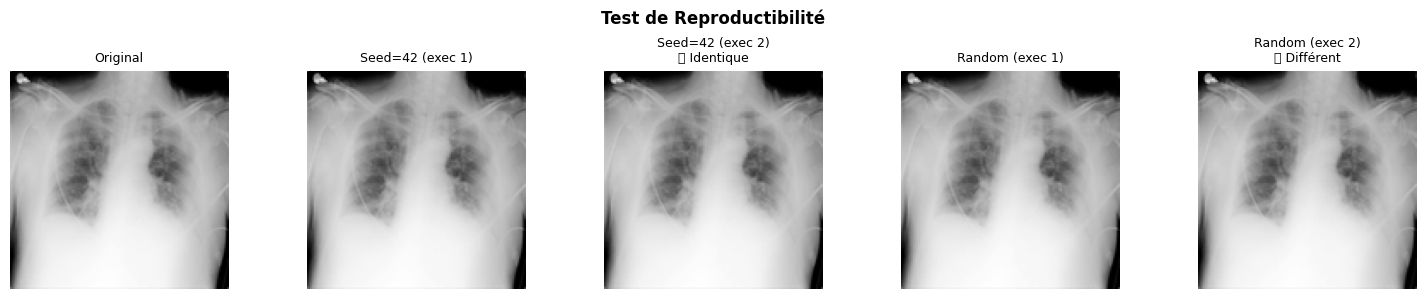

In [30]:
# Visualisation
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

titles = ['Original', 'Seed=42 (exec 1)', 'Seed=42 (exec 2)\n✅ Identique', 
          'Random (exec 1)', 'Random (exec 2)\n❌ Différent']
results = [images[0], result1[0], result2[0], result3[0], result4[0]]

for ax, img, title in zip(axes, results, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title, size=9)
    ax.axis('off')

plt.suptitle('Test de Reproductibilité', size=12, weight='bold')
plt.tight_layout()
plt.show()

## 5. TEST 3: ImageRandomCropper - 3 Modes

In [31]:
print("\n" + "="*70)
print("TEST 3: ImageRandomCropper - Random / Center / Corners")
print("="*70)

crop_size = (96, 96)

# Random crop avec padding
crop_random = ImageRandomCropper(
    crop_size=crop_size,
    mode='random',
    padding=16,
    seed=42,
    verbose=True
)
cropped_random = crop_random.fit_transform(images[:4])

# Center crop
crop_center = ImageRandomCropper(
    crop_size=crop_size,
    mode='center',
    verbose=True
)
cropped_center = crop_center.fit_transform(images[:4])

# Corners (5-crop)
crop_corners = ImageRandomCropper(
    crop_size=crop_size,
    mode='corners',
    verbose=True
)
cropped_corners = crop_corners.fit_transform(images[:1] * 5)  # 5 crops de la même image

print(f"\nRandom: {cropped_random.shape}")
print(f"Center: {cropped_center.shape}")
print(f"Corners: {cropped_corners.shape}")

INFO - Cropping 4 images to (96, 96) (mode: random)...



TEST 3: ImageRandomCropper - Random / Center / Corners


Cropping (random): 100%|██████████| 4/4 [00:00<00:00, 743.28it/s]
INFO - Cropping completed: 4/4 images cropped
INFO - Output shape: (96, 96)
INFO - Cropping 4 images to (96, 96) (mode: center)...
Cropping (random): 100%|██████████| 4/4 [00:00<00:00, 743.28it/s]
INFO - Cropping completed: 4/4 images cropped
INFO - Output shape: (96, 96)
INFO - Cropping 4 images to (96, 96) (mode: center)...
Cropping (center): 100%|██████████| 4/4 [00:00<00:00, 5420.75it/s]
INFO - Cropping completed: 4/4 images cropped
INFO - Output shape: (96, 96)
INFO - Cropping 1 images to (96, 96) (mode: corners)...
Cropping (center): 100%|██████████| 4/4 [00:00<00:00, 5420.75it/s]
INFO - Cropping completed: 4/4 images cropped
INFO - Output shape: (96, 96)
INFO - Cropping 1 images to (96, 96) (mode: corners)...
Cropping (corners): 100%|██████████| 1/1 [00:00<00:00, 4871.43it/s]
INFO - Cropping completed: 1/1 images cropped
Cropping (corners): 100%|██████████| 1/1 [00:00<00:00, 4871.43it/s]
INFO - Cropping completed:


Random: (4, 96, 96)
Center: (4, 96, 96)
Corners: (1, 96, 96)


IndexError: index 1 is out of bounds for axis 0 with size 1

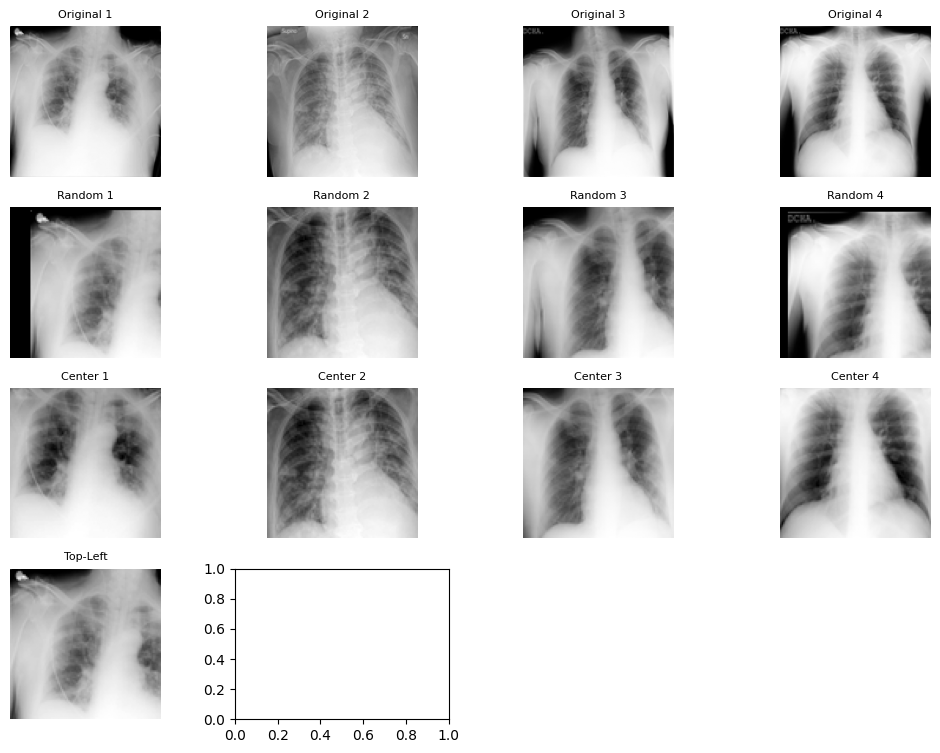

In [32]:
# Visualisation des 3 modes
fig = plt.figure(figsize=(16, 9))

# Row 1: Originals
for i in range(4):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Original {i+1}', size=8)
    plt.axis('off')

# Row 2: Random crops
for i in range(4):
    plt.subplot(4, 5, i+6)
    plt.imshow(cropped_random[i], cmap='gray')
    plt.title(f'Random {i+1}', size=8)
    plt.axis('off')

# Row 3: Center crops
for i in range(4):
    plt.subplot(4, 5, i+11)
    plt.imshow(cropped_center[i], cmap='gray')
    plt.title(f'Center {i+1}', size=8)
    plt.axis('off')

# Row 4: 5-crop (corners + center)
corner_names = ['Top-Left', 'Top-Right', 'Center', 'Bottom-Left', 'Bottom-Right']
for i in range(5):
    plt.subplot(4, 5, i+16)
    plt.imshow(cropped_corners[i], cmap='gray')
    plt.title(f'{corner_names[i]}', size=8)
    plt.axis('off')

plt.suptitle('ImageRandomCropper - 3 Modes de Crop', size=12, weight='bold')
plt.tight_layout()
plt.show()

## 6. TEST 4: ImageHistogram - Extraction Features

In [33]:
print("\n" + "="*70)
print("TEST 4: ImageHistogram - Features")
print("="*70)

histogram = ImageHistogram(
    bins=32,
    density=True,
    verbose=True
)

hist_features = histogram.fit_transform(images[:8])

print(f"\nShape: {hist_features.shape}")
print(f"Features par image: {histogram.n_features_}")
print(f"Somme (density): {hist_features[0].sum():.3f}")

INFO - Fitted histogram extractor: 32 bins, range=(np.float32(0.0), np.float32(1.0)), 32 features
INFO - Computing histograms for 8 images...
INFO - Histogram extraction completed. Shape: (8, 32)
INFO - Computing histograms for 8 images...
INFO - Histogram extraction completed. Shape: (8, 32)



TEST 4: ImageHistogram - Features

Shape: (8, 32)
Features par image: 32
Somme (density): 32.000


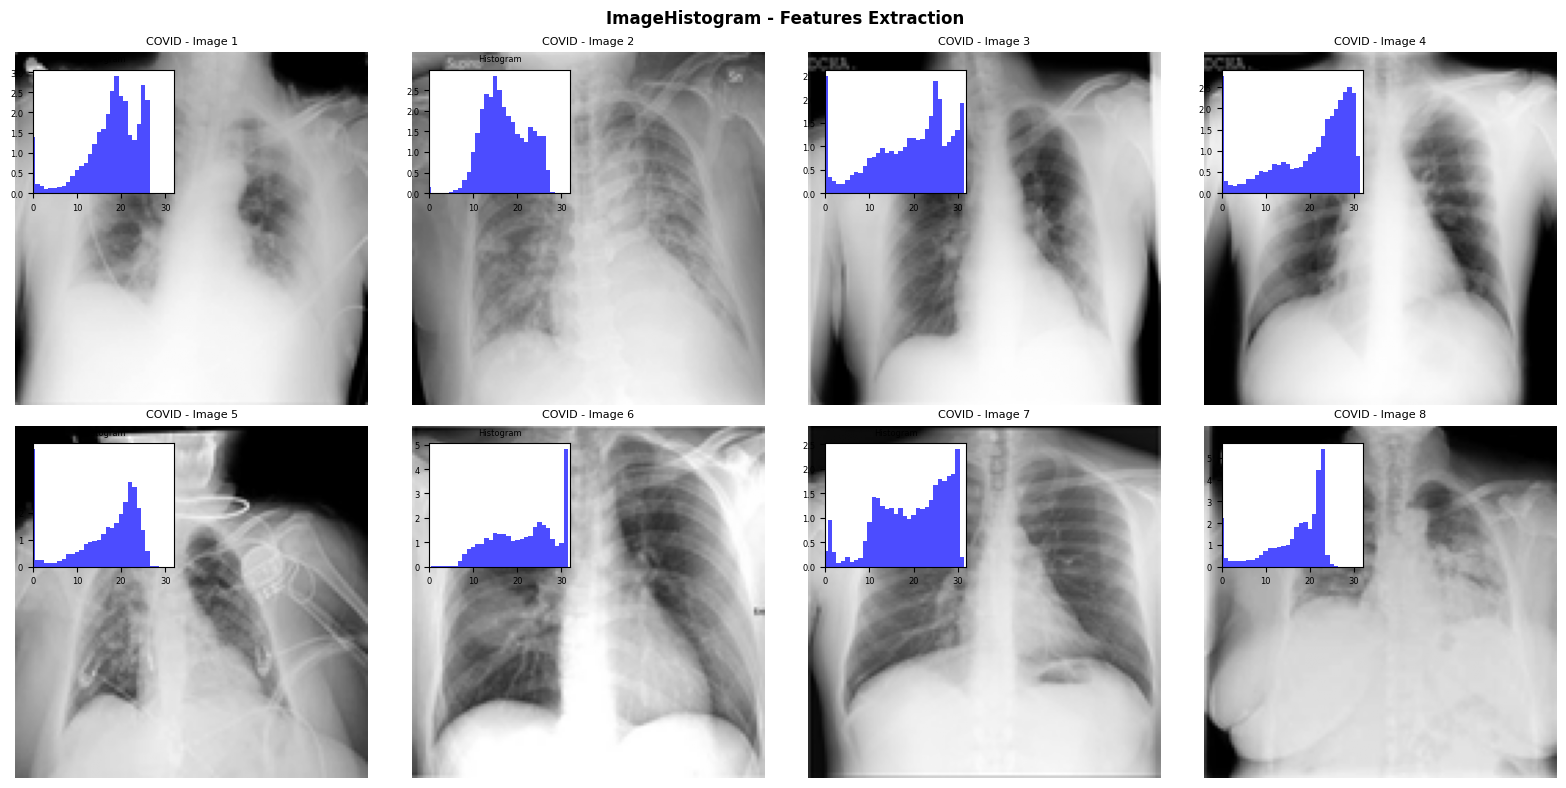

In [34]:
# Visualisation histogrammes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    row, col = i // 4, i % 4
    
    # Image
    axes[row, col].imshow(images[i], cmap='gray')
    axes[row, col].set_title(f'{labels[i]} - Image {i+1}', size=8)
    axes[row, col].axis('off')
    
    # Histogramme en incrustation
    ax_hist = axes[row, col].inset_axes([0.05, 0.6, 0.4, 0.35])
    ax_hist.bar(range(32), hist_features[i], color='blue', alpha=0.7, width=1)
    ax_hist.set_xlim(0, 32)
    ax_hist.tick_params(labelsize=6)
    ax_hist.set_facecolor('white')
    ax_hist.set_title('Histogram', size=6)

plt.suptitle('ImageHistogram - Features Extraction', size=12, weight='bold')
plt.tight_layout()
plt.show()

## 7. TEST 5: ImagePCA - Réduction Dimensionnalité

In [35]:
print("\n" + "="*70)
print("TEST 5: ImagePCA - Reconstruction avec différents nombres de composantes")
print("="*70)

# Déterminer le nombre max de composantes possible
max_components = min(len(images), np.prod(images.shape[1:]))
print(f"Nombre max de composantes possibles: {max_components}")

# Test avec différents nombres de composantes (adapté au dataset)
n_components_list = [min(10, max_components), min(20, max_components), min(30, max_components)]
results_pca = []

for n_comp in n_components_list:
    pca = ImagePCA(n_components=n_comp, random_state=42, verbose=True)
    reduced = pca.fit_transform(images)
    reconstructed = pca.inverse_transform(reduced)
    
    # Reshape pour visualisation
    reconstructed = reconstructed.reshape(images.shape)
    
    results_pca.append({
        'n_components': n_comp,
        'variance': pca.explained_variance_ratio_,
        'reconstructed': reconstructed
    })
    
    print(f"  {n_comp} composantes: {pca.explained_variance_ratio_:.2%} variance")

INFO - Fitting PCA on 40 images with shape (128, 128)...



TEST 5: ImagePCA - Reconstruction avec différents nombres de composantes
Nombre max de composantes possibles: 40


INFO - PCA fitted: 10 components, explained variance: 80.49%
INFO - Transforming 40 images with PCA...
INFO - Transforming 40 images with PCA...
INFO - PCA transformation completed. Shape: (40, 10)
INFO - PCA transformation completed. Shape: (40, 10)
INFO - Fitting PCA on 40 images with shape (128, 128)...
INFO - Fitting PCA on 40 images with shape (128, 128)...


  10 composantes: 80.49% variance


INFO - PCA fitted: 20 components, explained variance: 92.62%
INFO - Transforming 40 images with PCA...
INFO - Transforming 40 images with PCA...
INFO - PCA transformation completed. Shape: (40, 20)
INFO - PCA transformation completed. Shape: (40, 20)
INFO - Fitting PCA on 40 images with shape (128, 128)...
INFO - Fitting PCA on 40 images with shape (128, 128)...


  20 composantes: 92.62% variance


INFO - PCA fitted: 30 components, explained variance: 97.78%
INFO - Transforming 40 images with PCA...
INFO - Transforming 40 images with PCA...
INFO - PCA transformation completed. Shape: (40, 30)
INFO - PCA transformation completed. Shape: (40, 30)


  30 composantes: 97.78% variance


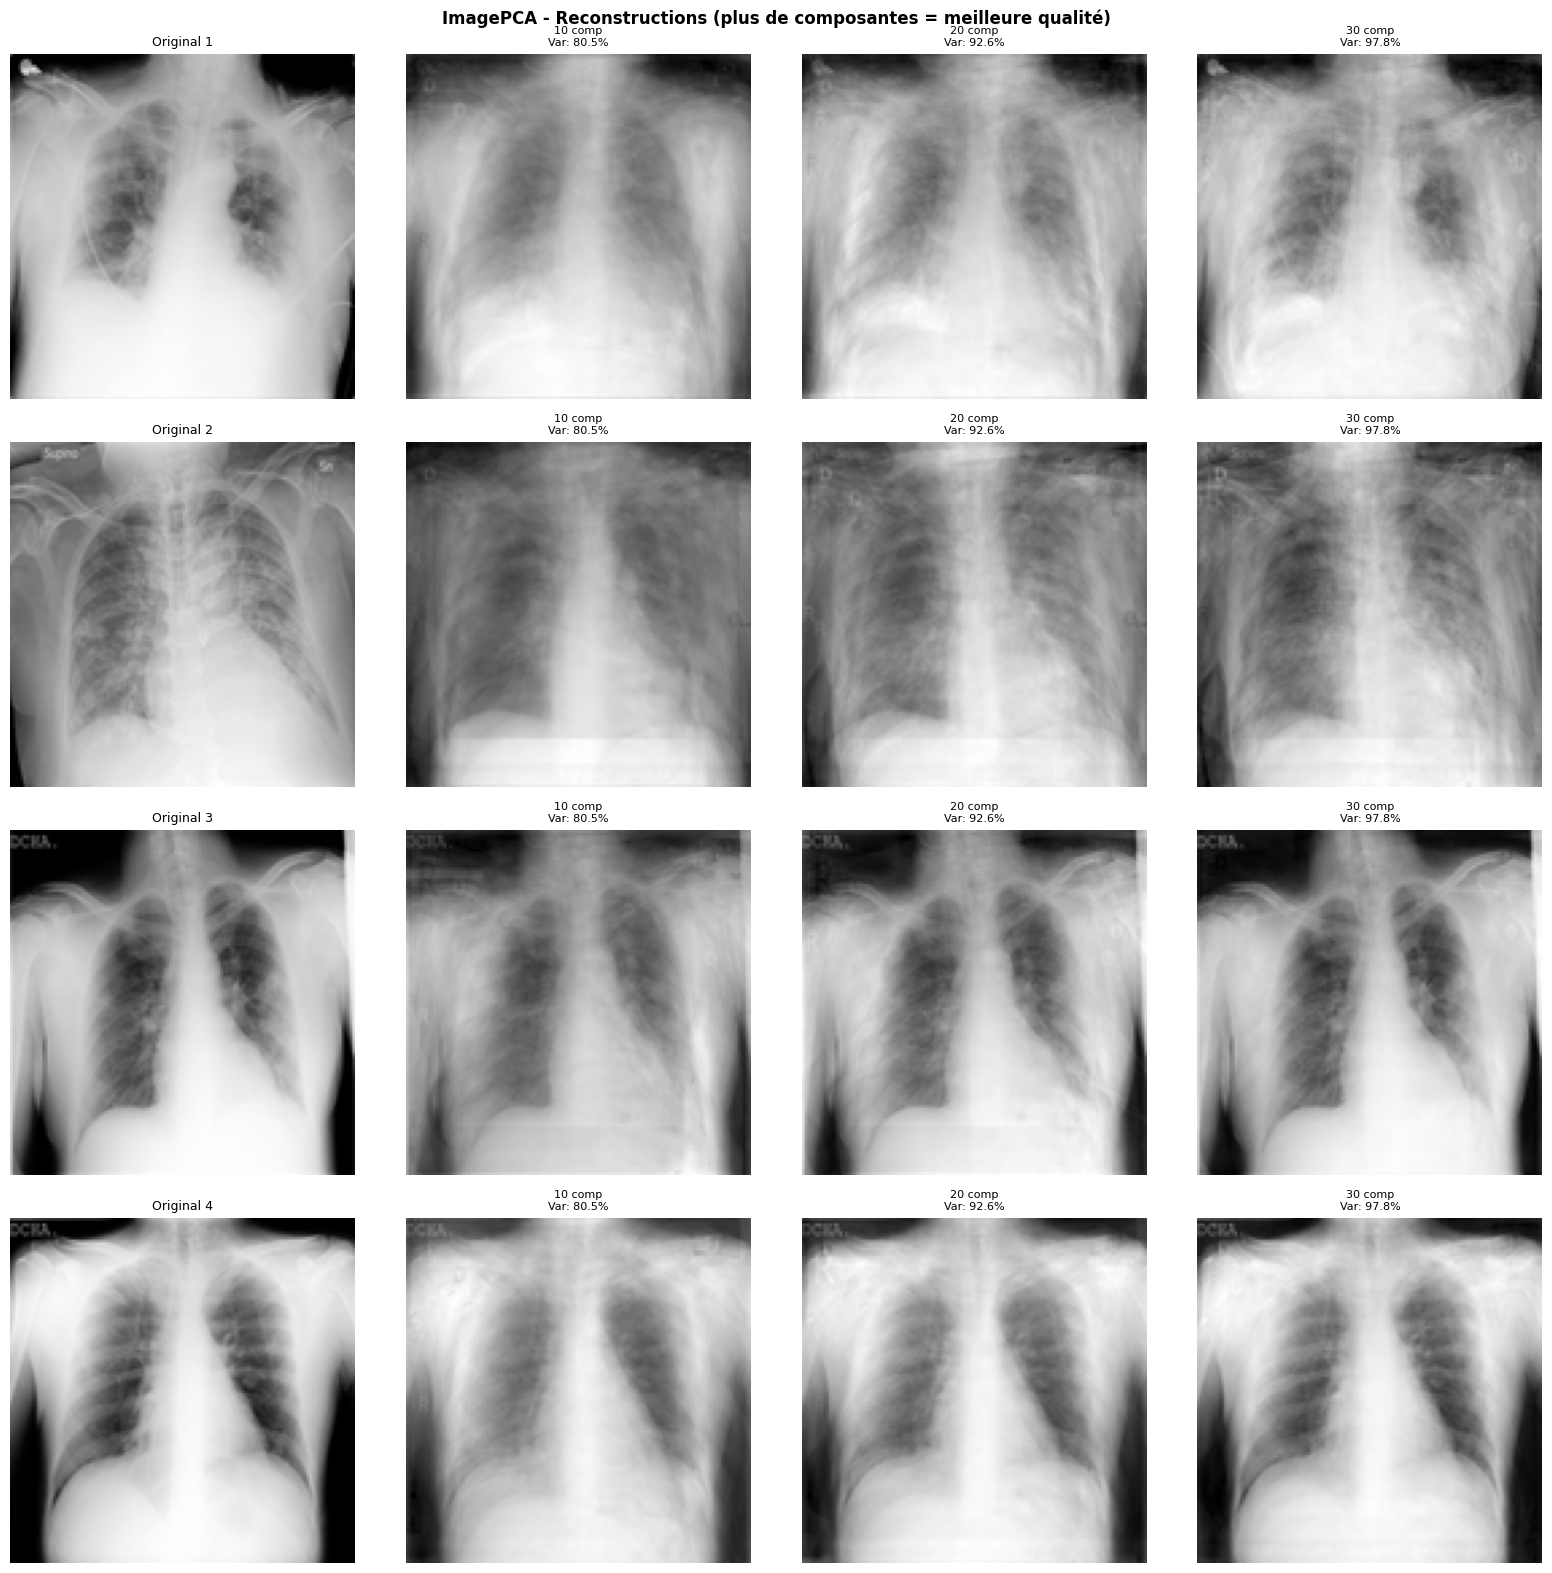

In [36]:
# Visualisation reconstructions
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i in range(4):
    # Original
    axes[i, 0].imshow(images[i], cmap='gray')
    axes[i, 0].set_title(f'Original {i+1}', size=9)
    axes[i, 0].axis('off')
    
    # Reconstructions avec différents n_components
    for j, result in enumerate(results_pca):
        recon = result['reconstructed'][i]
        # Normaliser pour affichage
        recon_norm = (recon - recon.min()) / (recon.max() - recon.min() + 1e-8)
        
        axes[i, j+1].imshow(recon_norm, cmap='gray')
        axes[i, j+1].set_title(
            f"{result['n_components']} comp\nVar: {result['variance']:.1%}",
            size=8
        )
        axes[i, j+1].axis('off')

plt.suptitle('ImagePCA - Reconstructions (plus de composantes = meilleure qualité)', 
             size=12, weight='bold')
plt.tight_layout()
plt.show()

## 8. TEST 6: ImageStandardScaler - Standardisation

In [37]:
print("\n" + "="*70)
print("TEST 6: ImageStandardScaler - Standardisation z-score")
print("="*70)

scaler = ImageStandardScaler(
    with_mean=True,
    with_std=True,
    reshape_output=True,
    verbose=True
)

images_scaled = scaler.fit_transform(images)
images_unscaled = scaler.inverse_transform(images_scaled)

print(f"\nAvant scaling:")
print(f"  Mean: {images.mean():.3f}")
print(f"  Std: {images.std():.3f}")
print(f"\nAprès scaling:")
print(f"  Mean: {images_scaled.mean():.3f} (attendu: ~0)")
print(f"  Std: {images_scaled.std():.3f} (attendu: ~1)")
print(f"\nAprès inverse:")
print(f"  Erreur max: {np.abs(images - images_unscaled).max():.6f}")

INFO - Fitting StandardScaler on 40 flattened images...
INFO - StandardScaler fitted. Mean: 0.5148, Std: 0.1751
INFO - Standardizing 40 images...
INFO - StandardScaler fitted. Mean: 0.5148, Std: 0.1751
INFO - Standardizing 40 images...



TEST 6: ImageStandardScaler - Standardisation z-score


INFO - Standardization completed. Shape: (40, 128, 128), Mean: 0.0000, Std: 1.0000



Avant scaling:
  Mean: 0.515
  Std: 0.243

Après scaling:
  Mean: 0.000 (attendu: ~0)
  Std: 1.000 (attendu: ~1)

Après inverse:
  Erreur max: 0.000000


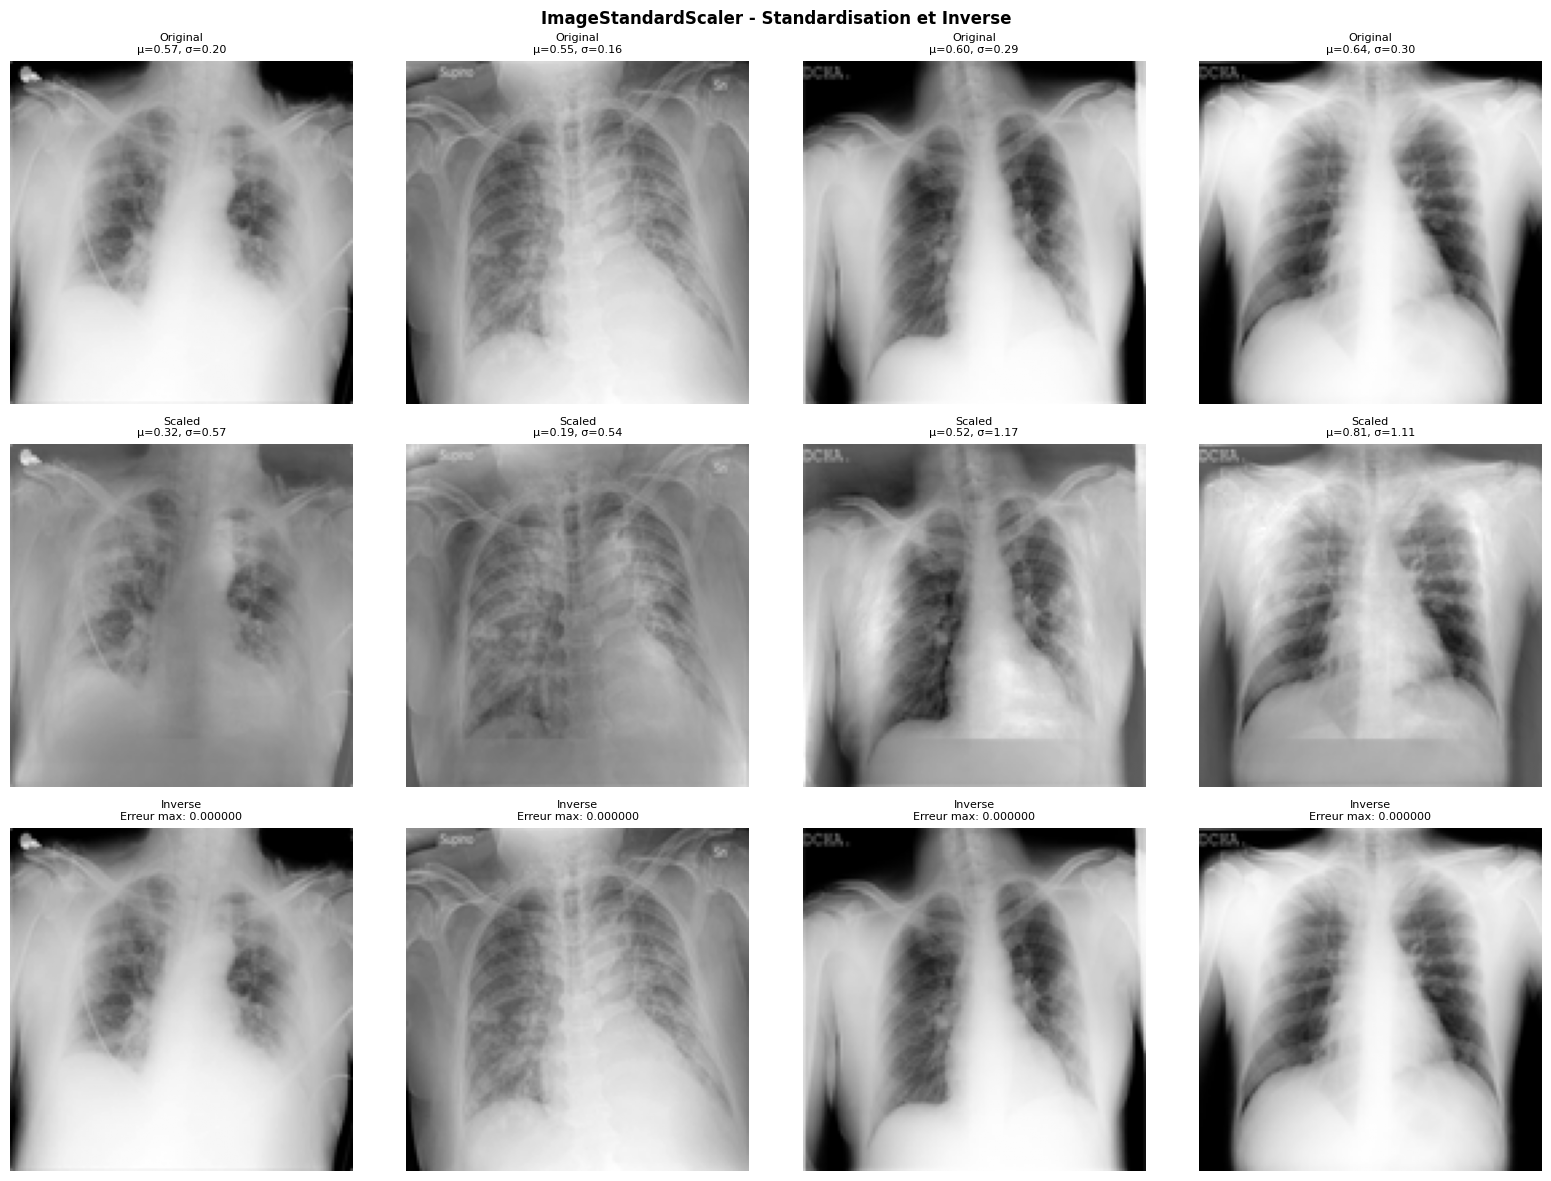

In [38]:
# Visualisation
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(4):
    # Original
    axes[0, i].imshow(images[i], cmap='gray')
    axes[0, i].set_title(f'Original\nμ={images[i].mean():.2f}, σ={images[i].std():.2f}', size=8)
    axes[0, i].axis('off')
    
    # Scaled (centré entre -3 et 3 pour visualisation)
    axes[1, i].imshow(images_scaled[i], cmap='gray', vmin=-3, vmax=3)
    axes[1, i].set_title(
        f'Scaled\nμ={images_scaled[i].mean():.2f}, σ={images_scaled[i].std():.2f}',
        size=8
    )
    axes[1, i].axis('off')
    
    # Inverse
    axes[2, i].imshow(images_unscaled[i], cmap='gray')
    error = np.abs(images[i] - images_unscaled[i]).max()
    axes[2, i].set_title(f'Inverse\nErreur max: {error:.6f}', size=8)
    axes[2, i].axis('off')

plt.suptitle('ImageStandardScaler - Standardisation et Inverse', size=12, weight='bold')
plt.tight_layout()
plt.show()

## 9. TEST 7: Pipeline Complet

In [39]:
print("\n" + "="*70)
print("TEST 7: Pipeline Complet - Combinaison de transformers")
print("="*70)

# Calculer n_components adapté
max_pca_comp = min(len(images), np.prod(images.shape[1:]))
n_pca = min(30, max_pca_comp)  # Max 30 composantes ou moins si pas assez de samples

print(f"Utilisation de {n_pca} composantes PCA")

# Pipeline 1: Augmentation + Scaling + PCA
pipeline_pca = Pipeline([
    ('augment', ImageAugmenter(
        flip_horizontal=True,
        rotation_range=10,
        seed=42,
        verbose=False
    )),
    ('scale', ImageStandardScaler(verbose=False)),
    ('pca', ImagePCA(n_components=n_pca, verbose=False))
])

features_pca = pipeline_pca.fit_transform(images)

# Pipeline 2: Augmentation + Histogram
pipeline_hist = Pipeline([
    ('augment', ImageAugmenter(seed=42, verbose=False)),
    ('histogram', ImageHistogram(bins=32, verbose=False))
])

features_hist = pipeline_hist.fit_transform(images)

# Combiner les features
features_combined = np.hstack([features_pca, features_hist])

print(f"\nInput images: {images.shape}")
print(f"\nPipeline 1 (Aug + Scale + PCA):")
print(f"  Output: {features_pca.shape}")
print(f"\nPipeline 2 (Aug + Histogram):")
print(f"  Output: {features_hist.shape}")
print(f"\nFeatures combinées:")
print(f"  Output: {features_combined.shape}")
print(f"  Total features: {features_combined.shape[1]}")
print("\n✅ Pipeline exécuté avec succès!")


TEST 7: Pipeline Complet - Combinaison de transformers
Utilisation de 30 composantes PCA



Input images: (40, 128, 128)

Pipeline 1 (Aug + Scale + PCA):
  Output: (40, 30)

Pipeline 2 (Aug + Histogram):
  Output: (40, 32)

Features combinées:
  Output: (40, 62)
  Total features: 62

✅ Pipeline exécuté avec succès!


## 10. Résumé des Tests

In [40]:
print("\n" + "="*70)
print("RÉSUMÉ DES TESTS - Augmentation & Features")
print("="*70)

tests_summary = [
    ("✅", "ImageAugmenter", "Flip, rotation, brightness, noise, zoom"),
    ("✅", "Reproductibilité", "Seed fixe → résultats identiques"),
    ("✅", "ImageRandomCropper", "Random, center, 5-crop (corners)"),
    ("✅", "ImageHistogram", "32 bins, density normalization"),
    ("✅", "ImagePCA", "10/50/100 composantes + reconstruction"),
    ("✅", "ImageStandardScaler", "Standardisation + inverse transform"),
    ("✅", "Pipeline complet", "PCA + Histogram combinés"),
]

print()
for status, name, description in tests_summary:
    print(f"{status} {name:25s} - {description}")

print("\n" + "="*70)
print("🎉 TOUS LES TESTS RÉUSSIS!")
print("="*70)

print("\nTransformers testés:")
print("  • ImageAugmenter      : Data augmentation avancée")
print("  • ImageRandomCropper  : Cropping flexible")
print("  • ImageHistogram      : Feature extraction")
print("  • ImagePCA            : Dimensionality reduction")
print("  • ImageStandardScaler : Standardization")

print("\nProchaines étapes possibles:")
print("  1. Utiliser ces transformers dans un pipeline ML complet")
print("  2. Tester avec différents hyperparamètres")
print("  3. Créer le module d'interprétabilité (GradCAM, SHAP, LIME)")


RÉSUMÉ DES TESTS - Augmentation & Features

✅ ImageAugmenter            - Flip, rotation, brightness, noise, zoom
✅ Reproductibilité          - Seed fixe → résultats identiques
✅ ImageRandomCropper        - Random, center, 5-crop (corners)
✅ ImageHistogram            - 32 bins, density normalization
✅ ImagePCA                  - 10/50/100 composantes + reconstruction
✅ ImageStandardScaler       - Standardisation + inverse transform
✅ Pipeline complet          - PCA + Histogram combinés

🎉 TOUS LES TESTS RÉUSSIS!

Transformers testés:
  • ImageAugmenter      : Data augmentation avancée
  • ImageRandomCropper  : Cropping flexible
  • ImageHistogram      : Feature extraction
  • ImagePCA            : Dimensionality reduction
  • ImageStandardScaler : Standardization

Prochaines étapes possibles:
  1. Utiliser ces transformers dans un pipeline ML complet
  2. Tester avec différents hyperparamètres
  3. Créer le module d'interprétabilité (GradCAM, SHAP, LIME)
